In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Importing necessary modules and functions from your files
from GIANTS_data_load_and_preprocessing import load_data, preprocess_data
from GIANTS_kano_analysis import (get_feature_names, prepare_kano_data, apply_kano_scoring, calculate_kano_averages, plot_kano_results, 
                                  plot_kano_by_age_group, plot_feature_means_with_std
)
from GIANTS_clustering import preprocess_for_clustering, perform_clustering, plot_elbow_method



# Step 1: Load the data
df = pd.read_excel('C:/Users/TomiNordi2m/OneDrive - i2m Unternehmensentwicklung GmbH/Documents/Python/GIANTS Survey Data Analysis/2024.10.21 GIANTS project_ User and stakeholder needs survey (Responses).xlsx')
#file_path = "C:/Users/TomiNordi2m/OneDrive - i2m Unternehmensentwicklung GmbH/Documents/Python/GIANTS Survey Data Analysis/Copy of 2024.09.12 GIANTS project_ User and stakeholder needs survey (Responses).xlsx"
#df = load_data(file_path)

# Step 2: Preprocess the data
#df = preprocess_data(df)







## Subgroup Filtering Definition

In [2]:

# Define the age categories for retirees
retiree_ages = ['60-78', '>78']

# Filter the dataframe for respondents within the retiree age range
df_retiree = df[df['2. Age'].isin(retiree_ages)]

# Define keywords related to work for primary and secondary use filtering
work_related_keywords = ['work', 'commuting']

# Function to check if any of the work-related keywords are present
def not_work_related(usage):
    if pd.isnull(usage):
        return True  # Keep null values (assuming these could be retirees too)
    usage = str(usage)  # Convert to string to avoid errors with numeric entries
    return not any(keyword in usage.lower() for keyword in work_related_keywords)

# Apply the filtering on both primary and secondary usage
df_retiree = df_retiree[df_retiree['16. How do you generally use your primary mode of transportation? (Multiple answers allowed.)'].apply(not_work_related)]
df_retiree = df_retiree[df_retiree['21. How do you generally use your secondary mode of transportation? (Multiple answers allowed.)'].apply(not_work_related)]

# Get the count of how many people fulfill the retiree criteria
retiree_count = len(df_retiree)

# Output the count
print(f"Number of respondents who fulfill the retiree criteria: {retiree_count}")


Number of respondents who fulfill the retiree criteria: 30


In [3]:
# Define the age range for students
student_ages = ['18-29']  # Adjust based on the dataset categories

# Define the low-income ranges based on the income column
low_income_ranges = [
    '0 - 2,500€', 
    '2,500 - 5,000€', 
    '5,000 - 10,000€', 
    '10,000 - 25,000€'
]

# Filter the dataframe for respondents within the student age range
df_student = df[df['2. Age'].isin(student_ages)]

# Further filter for respondents within the low-income ranges
df_student = df_student[df_student['9.  Estimated annual household (family) income in 2023 in Euros (€/EUR)? (Link to EU Currency Converter)'].isin(low_income_ranges)]

# Get the count of how many people fulfill the student criteria
student_count = len(df_student)

# Output the count
print(f"Number of respondents who fulfill the student criteria: {student_count}")

# The resulting filtered dataframe `df_student` will now contain only students




Number of respondents who fulfill the student criteria: 22


In [4]:
# Combine the two columns to calculate total household size
df['Total Household Size'] = (
    pd.to_numeric(df['8. How many people  / family members live in your household? (for safety related questions) [Adults (18 and older)]'], errors='coerce') +
    pd.to_numeric(df['8. How many people  / family members live in your household? (for safety related questions) [Kids (6-17)]'], errors='coerce')
)

# Filter for families with total household size >= 2
df_family = df[df['Total Household Size'] >= 2]

# Further filter for households with at least one child
df_family = df_family[df['8. How many people  / family members live in your household? (for safety related questions) [Kids (6-17)]'] > 0]

# Output the count of families with kids
family_with_kids_count = len(df_family)
print(f"Number of families with kids: {family_with_kids_count}")



Number of families with kids: 91


C:\Users\TomiNordi2m\AppData\Local\Temp\ipykernel_9844\1175133733.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_family = df_family[df['8. How many people  / family members live in your household? (for safety related questions) [Kids (6-17)]'] > 0]


In [5]:
# Calculate total household size
df['Total Household Size'] = (
    pd.to_numeric(df['8. How many people  / family members live in your household? (for safety related questions) [Adults (18 and older)]'], errors='coerce').fillna(0) +
    pd.to_numeric(df['8. How many people  / family members live in your household? (for safety related questions) [Kids (6-17)]'], errors='coerce').fillna(0)
)

# Define the age ranges to include
single_person_ages = ['30-44', '45-65']  # Adjust based on the actual categories in your dataset

# Filter for single-person households
df_single_person = df[df['Total Household Size'] == 1]

# Further filter for respondents within the specified age ranges
df_single_person = df_single_person[df_single_person['2. Age'].isin(single_person_ages)]

# Output the count of single-person households within the age ranges
single_person_age_filtered_count = len(df_single_person)
print(f"Number of single-person households aged 30-44 or 45-65: {single_person_age_filtered_count}")


Number of single-person households aged 30-44 or 45-65: 9


In [6]:
# Filter respondents whose trip purpose involves work-related usage
df_service_providers = df[
    df['16. How do you generally use your primary mode of transportation? (Multiple answers allowed.)'].isin([
        'Vehicle is my work tool (for passenger transport)',
        'Vehicle is my work tool (for cargo/delivery)'
    ])
]

# Count the number of service providers identified
service_provider_count = len(df_service_providers)
print(f"Number of service providers identified: {service_provider_count}")


Number of service providers identified: 6


In [7]:
df = df_family

In [8]:

# Step 3: Prepare Kano data
df_kano = prepare_kano_data(df)

# Step 4: Get feature names for Kano analysis
feature_names = get_feature_names()


# Step 5: Apply Kano scoring
df_kano = apply_kano_scoring(df_kano, feature_names)

# Step 6: Calculate Kano averages
df_averages = calculate_kano_averages(df_kano, feature_names)

# Step 7: Plot Kano results 
plot_kano_results(df_averages)


In [9]:
def plot_kano_results_with_errors(df_averages, plot_title='Kano Model with Errors'):
    """Plots Kano results using Plotly with error bars for functional and dysfunctional scores."""
    fig = px.scatter(df_averages,
                     x='Average Dysfunctional Score',
                     y='Average Functional Score',
                     text='Feature', 
                     title=plot_title,
                     error_x='Dysfunctional StdDev',  # Add standard deviation for dysfunctional scores
                     error_y='Functional StdDev')  # Add standard deviation for functional scores

   

# Step 6: Calculate Kano averages
df_averages = calculate_kano_averages(df_kano, feature_names)


# Step 7: Plot Kano results with standard deviations
plot_kano_results(df_averages)

In [10]:
#plot_interactive_scatter_for_feature(df_kano, 'Doors')

c:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\GIANTS Survey Data Analysis\GIANTS_kano_analysis.py:94: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

c:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\GIANTS Survey Data Analysis\GIANTS_kano_analysis.py:98: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



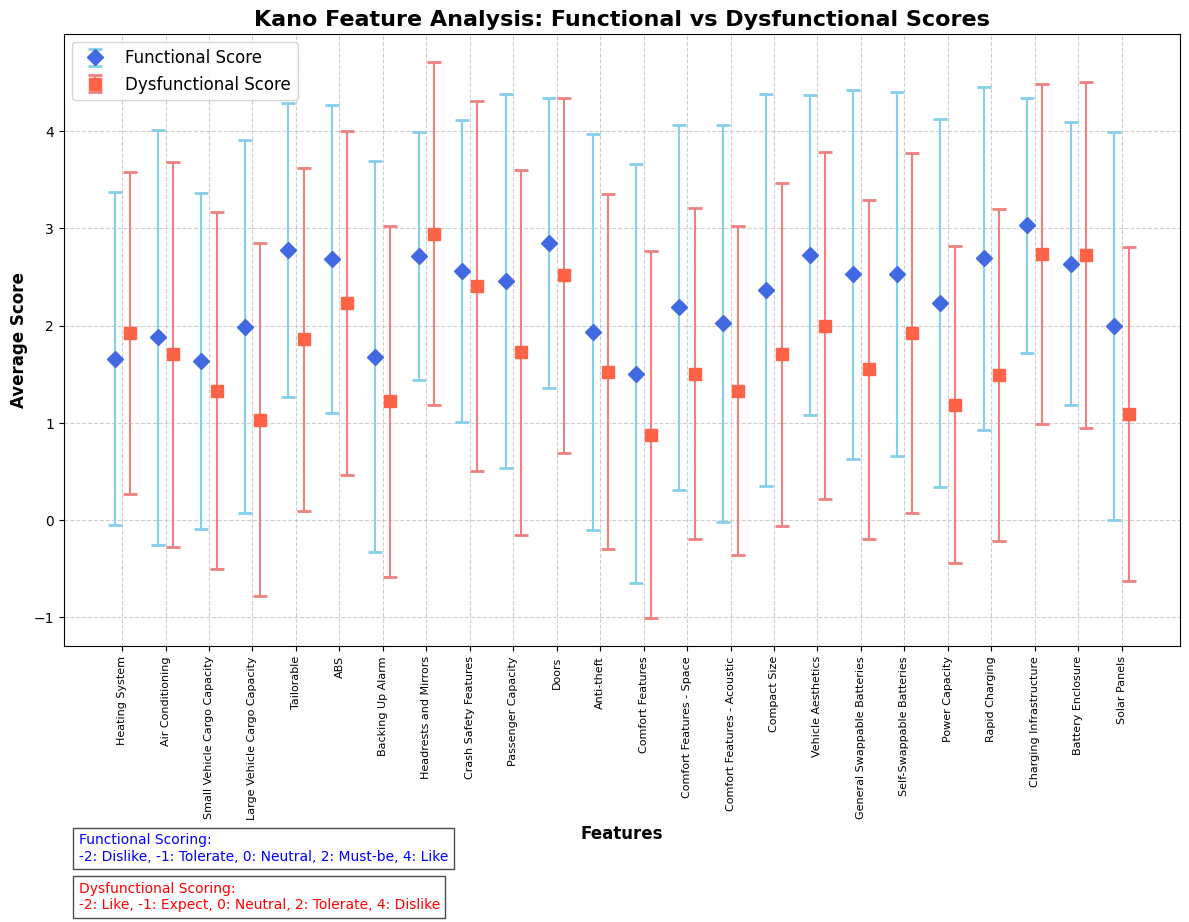

In [11]:
#Standard Deviations of Features
plot_feature_means_with_std(df_averages)


In [12]:
# Step 8: Plot Kano analysis for each age group (set show_plot to False to avoid showing)
#plot_kano_by_age_group(df, df_kano, feature_names)

In [13]:
#kano_analysis_for_students(df, df_kano, feature_names)

In [14]:

# Step 9: Plot the market distribution
#plot_market_distribution(df)


# Plot age distribution
#plot_age_distribution(df)

# Plot income distribution
#plot_income_distribution(df)

#Plot user type distribution
#plot_user_type_distribution(df)


#df = apply_persona_classification(df)

# Print the first few rows to check the classified personas
#print(df[['Persona']].head(20))

In [15]:
# Preprocess specifically for clustering (inside the clustering module)
df_scaled, df_encoded = preprocess_for_clustering(df)

# Perform clustering
df_with_clusters = perform_clustering(df_scaled, df_encoded)

# Plot the elbow method to find the optimal number of clusters
plot_elbow_method(df_scaled, max_clusters=10)




KeyError: "None of [Index(['age', 'market', 'gender', 'city_type', 'user_type', 'education',\n       'income', 'mode', 'purpose'],\n      dtype='object')] are in the [columns]"

In [ ]:
# 4. Visualize clusters using PCA

pca, df_pca = pca_and_visualize(df_scaled, df_with_clusters)


NameError: name 'pca_and_visualize' is not defined

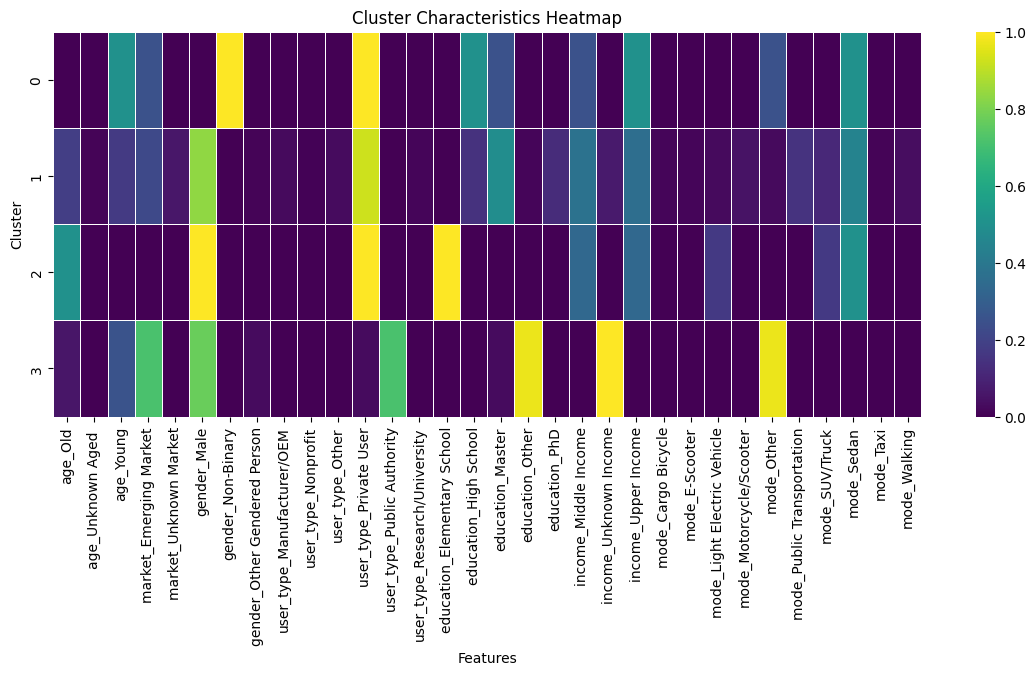

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by cluster and compute the mean of each feature to see the average profile per cluster
cluster_summary = df_with_clusters.groupby('cluster').mean()

# Create a heatmap for cluster characteristics with smaller cells and without numbers inside
plt.figure(figsize=(14, 5))  # Adjust the figure size to make cells less tall
sns.heatmap(cluster_summary, cmap='viridis', annot=False, linewidths=0.5, cbar=True)  # Set annot to False to remove numbers inside
plt.title('Cluster Characteristics Heatmap')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.xticks(rotation=90)
plt.show()



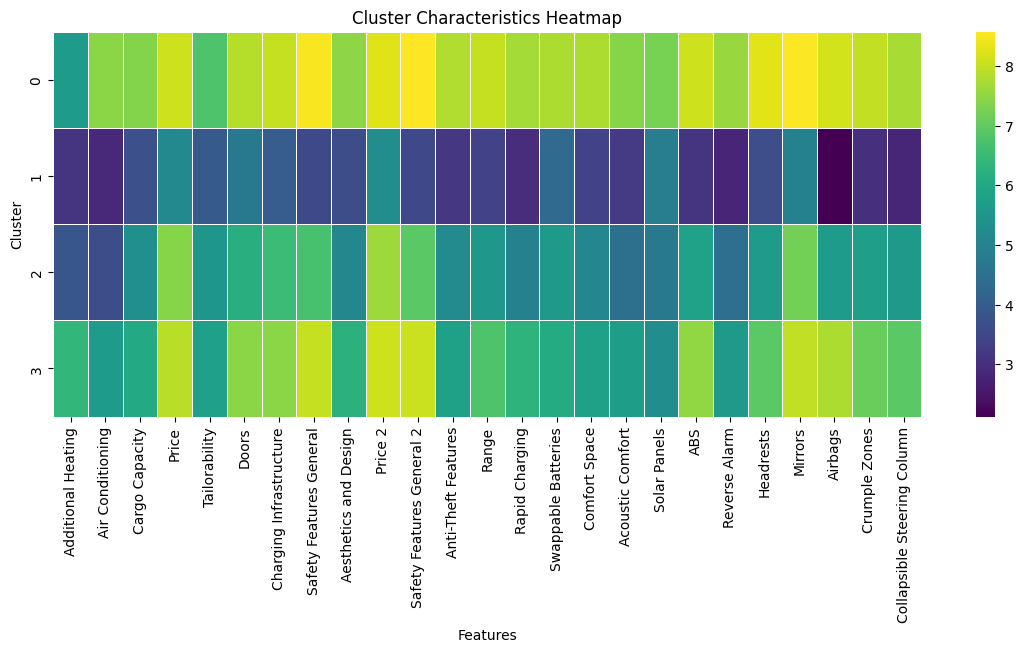

In [ ]:
# Step 1: Define the importance columns (i.e., vehicle feature columns: questions 55, 56, and 57)
# Define vehicle feature columns based on the newly renamed columns
vehicle_features_columns = [
    'Additional Heating', 
    'Air Conditioning', 
    'Cargo Capacity', 
    'Price', 
    'Tailorability', 
    'Doors', 
    'Charging Infrastructure', 
    'Safety Features General', 
    'Aesthetics and Design', 
    'Price 2', 
    'Safety Features General 2', 
    'Anti-Theft Features', 
    'Range', 
    'Rapid Charging', 
    'Swappable Batteries', 
    'Comfort Space', 
    'Acoustic Comfort', 
    'Solar Panels', 
    'ABS', 
    'Reverse Alarm', 
    'Headrests', 
    'Mirrors', 
    'Airbags', 
    'Crumple Zones', 
    'Collapsible Steering Column'
]


# Step 2: Preprocess the data for clustering (impute missing values, then scale)
df_scaled, df_importance_imputed = preprocess_numerical_for_clustering(df, vehicle_features_columns)

# Step 3: Perform clustering using the existing function
n_clusters = 4  # Adjust the number of clusters as needed
df_with_clusters = perform_clustering(df_scaled, df_importance_imputed, n_clusters=n_clusters)

# Step 4: Visualize the clusters using PCA
pca, df_pca = pca_and_visualize(df_scaled, df_with_clusters)

# Step 5: Create a Cluster Characteristics Heatmap
# Group by cluster and compute the mean of each feature to see the average profile per cluster
cluster_summary = df_with_clusters.groupby('cluster').mean()

# Create a heatmap for cluster characteristics with smaller cells and without numbers inside
plt.figure(figsize=(14, 5))  # Adjust the figure size to make cells less tall
sns.heatmap(cluster_summary, cmap='viridis', annot=False, linewidths=0.5, cbar=True)  # Set annot to False to remove numbers inside
plt.title('Cluster Characteristics Heatmap')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.xticks(rotation=90)
plt.show()
